# OMMX Cookbook

In [1]:
from ommx.v1 import Instance, DecisionVariable

## Dataframe API

OMMX has utility APIs to get decision variables and constraints as [pandas.Dataframe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html). Let's consider following informative two-dimensional decision variables:

In [2]:
n = 2
m = 3

x = [
    DecisionVariable.integer(
        m*i+j,             # ID of the decision variable, this MUST be unique
        name="x",          # Name of this decision variable
        subscripts=[i, j], # Subscript, i.e. this decision variable is `x[i, j]`
        lower=-j,          # Lower bound
        upper=2*i,         # Upper bound
        description=f"({i},{j})-th decision variable",
    )
    for i in range(n)
    for j in range(m)
]

The ID and upper and lower bounds are necessary to define the mathematical problem. In addition, `DecisionVariable` can store additional informations for pre- and post-processing:

- `name` is a human-readable name of the decision variable.
- `subscripts` is a list of integers. In many mathematical programming situations, we define multi-dimensional decision variables like $x_{ij} \in \mathbb{Z}$ for $i \in [1, n]$ and $j \in [1, m]$. OMMX requires these decision variables must be distinguished by its ID, but also allows to store its subscripts.
- `description` is a human-readable description of this decision variable

These informations are stored in `Instance` object. Let's create an empty instance with these decision variables

In [3]:
instance1 = Instance.from_components(
    decision_variables=x,
    objective=0,
    constraints=[],
    sense=Instance.MINIMIZE,
)

Then, they can be get by `decision_variables` property as a dataframe:

In [4]:
instance1.decision_variables

,kind,lower,upper,name,subscripts,description
,,,,,,
id,,,,,,
0,integer,0.0,0.0,x,"[0, 0]","(0,0)-th decision variable"
1,integer,-1.0,0.0,x,"[0, 1]","(0,1)-th decision variable"
2,integer,-2.0,0.0,x,"[0, 2]","(0,2)-th decision variable"
3,integer,0.0,2.0,x,"[1, 0]","(1,0)-th decision variable"
4,integer,-1.0,2.0,x,"[1, 1]","(1,1)-th decision variable"
5,integer,-2.0,2.0,x,"[1, 2]","(1,2)-th decision variable"


There is another property, `parameters` of type `dict[str, str]` in `DecisionVariable` class. This is designed to use more complicated case, for example, the decision variables are labeled by the city name:

In [5]:
y = [
    DecisionVariable.binary(
        id,
        parameters={"place": place},
    )
    for id, place in enumerate(["tokyo", "kyoto", "tiba", "siga", "saga"])
]

This yields a dataframe with two-level columns:

In [6]:
Instance.from_components(
    decision_variables=y,
    objective=0,
    constraints=[],
    sense=Instance.MINIMIZE,
).decision_variables

,kind,lower,upper,name,subscripts,description,parameters
,,,,,,,place
id,,,,,,,
0,binary,0.0,1.0,,[],,tokyo
1,binary,0.0,1.0,,[],,kyoto
2,binary,0.0,1.0,,[],,tiba
3,binary,0.0,1.0,,[],,siga
4,binary,0.0,1.0,,[],,saga


## Dependency graph between decision variables and constraints

In [7]:
from ommx.testing import SingleFeasibleLPGenerator, DataType

In [8]:
generator = SingleFeasibleLPGenerator(5, data_type=DataType.INT)
instance = generator.get_v1_instance()
state = generator.get_v1_state()

In [9]:
solution = instance.evaluate(state)

In [10]:
instance.decision_variables

,kind,lower,upper,name,subscripts,description
,,,,,,
id,,,,,,
0,integer,-100.0,100.0,,[],
1,integer,-100.0,100.0,,[],
2,integer,-100.0,100.0,,[],
3,integer,-100.0,100.0,,[],
4,integer,-100.0,100.0,,[],


In [11]:
instance.constraints

,equality,type,used_ids,name,description
,,,,,
id,,,,,
0,=0,linear,"{0, 1, 2, 3, 4}",,
1,=0,linear,"{0, 1, 2, 3, 4}",,
2,=0,linear,"{0, 1, 2, 3, 4}",,
3,=0,linear,"{0, 1, 2, 3, 4}",,
4,=0,linear,"{0, 1, 2, 3, 4}",,


In [12]:
solution.decision_variables

,kind,lower,upper,name,subscripts,description
,,,,,,
id,,,,,,
0,integer,-100.0,100.0,,[],
1,integer,-100.0,100.0,,[],
2,integer,-100.0,100.0,,[],
3,integer,-100.0,100.0,,[],
4,integer,-100.0,100.0,,[],


In [13]:
solution.constraints

,equality,value,used_ids,name,description
,,,,,
id,,,,,
0,=0,0.0,"{0, 1, 2, 3, 4}",,
1,=0,0.0,"{0, 1, 2, 3, 4}",,
2,=0,0.0,"{0, 1, 2, 3, 4}",,
3,=0,0.0,"{0, 1, 2, 3, 4}",,
4,=0,0.0,"{0, 1, 2, 3, 4}",,


In [14]:
import networkx as nx
import matplotlib.pyplot as plt

In [15]:
vs = solution.decision_variables
cs = solution.constraints

G = nx.DiGraph()
G.add_nodes_from((0, id) for id in vs.index)
G.add_nodes_from((1, id) for id in cs.index)
G.add_edges_from(
    ((1, cid), (0, vid))
    for cid in cs.index
    for vid in cs["used_ids"][cid]
)

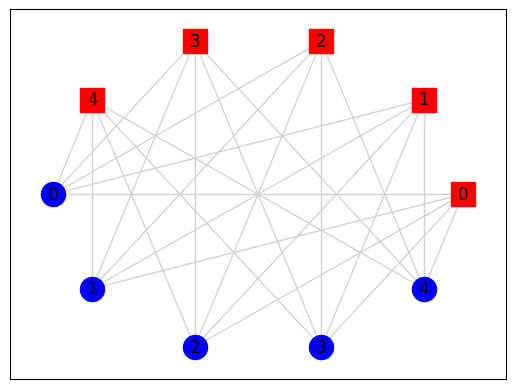

In [16]:
pos = nx.circular_layout(G)

# Draw decision variables as red squares
nx.draw_networkx_nodes(G, pos, nodelist=[(ty, id) for ty, id in G.nodes() if ty == 0], node_color='red', node_shape='s')

# Draw constraints as blue circles
nx.draw_networkx_nodes(G, pos, nodelist=[(ty, id) for ty, id in G.nodes() if ty == 1], node_color='blue', node_shape='o')

# The dependencies from constraints to decision variables are shown as gray edges
nx.draw_networkx_edges(G, pos, arrows=False, edge_color='lightgray')

# Labeled by their IDs
labels = {(ty, id): id for (ty, id) in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=labels)

plt.show()